In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
PRIMATE_DATA = 'milk.csv'
DATA_FOLDER = '../../data'

In [3]:
df = pd.read_csv(f'{DATA_FOLDER}/{PRIMATE_DATA}')
df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


## Explanation of Columns

* kcal.per.g = kcal per gram of milk
* mass = average female body mass in kg
* neocortex.perc = percentage of total brain mass that is neocortex

In [5]:
df = df.dropna()

## Standardlize Variables

### Code 5.28

In [6]:
from scipy.stats import zscore


df['kcal.per.g_stan'] = zscore(df['kcal.per.g'])

df['log_mass_stan'] = zscore(df['mass'].apply(np.log))

df['neocortex.perc_stan'] = zscore(df['neocortex.perc']) 

## First Model

In this model, we regress the energey content of milk in kilocalaries per gram with the neocortex mass. 
$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 1) \\
    \beta_N & \sim N(0, 1) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [7]:
with pm.Model() as m_5_5_draft:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_N = pm.Normal('beta_N', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5_draft = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


## Prior Predictive Plots

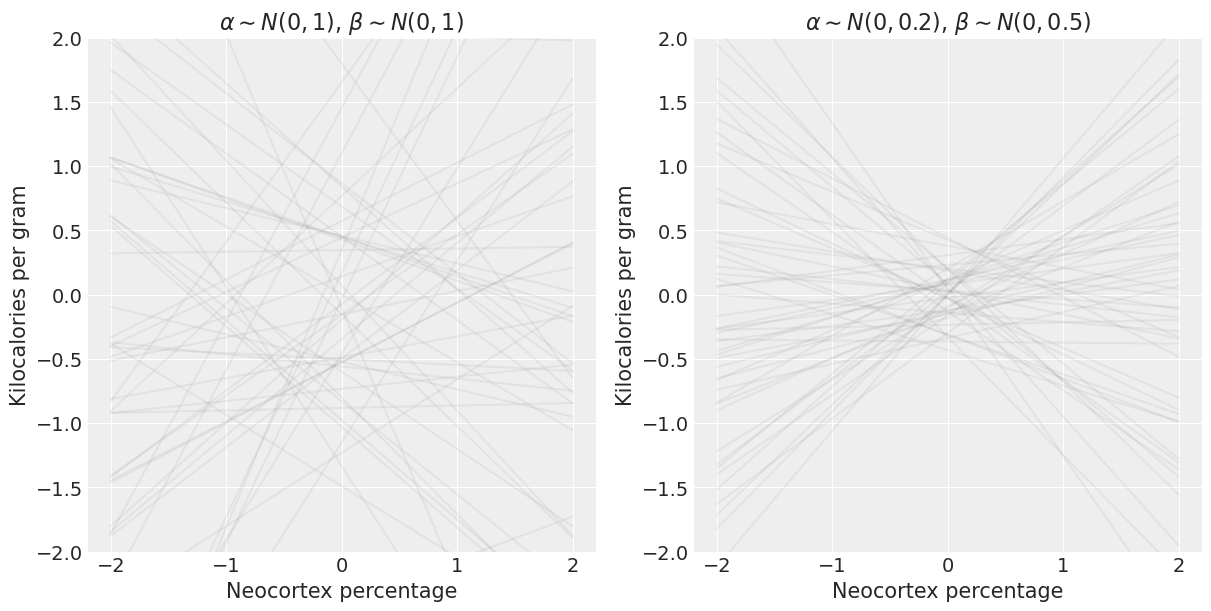

In [8]:
from scipy.stats import norm


N = 50

xvals = np.linspace(-2, 2, num=100)
a_1 = norm.rvs(loc=0, scale=1, size=N)
b_1 = norm.rvs(loc=0, scale=1, size=N)

a_2 = norm.rvs(loc=0, scale=0.2, size=N)
b_2 = norm.rvs(loc=0, scale=0.5, size=N)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 6))

for i in range(N):
    line_1 = a_1[i] + b_1[i] * xvals
    line_2 = a_2[i] + b_2[i] * xvals
    
    ax_1.plot(xvals, line_1, color='grey', alpha=0.1)
    ax_2.plot(xvals, line_2, color='grey', alpha=0.1)
    
ax_1.set_xlabel('Neocortex percentage')
ax_1.set_ylabel('Kilocalories per gram')
ax_1.set_ylim(-2, 2)

ax_2.set_xlabel('Neocortex percentage')
ax_2.set_ylabel('Kilocalories per gram')
ax_2.set_ylim(-2, 2)

ax_1.set_title(r'$\alpha \sim N(0,1)$, $\beta \sim N(0, 1)$')
ax_2.set_title(r'$\alpha \sim N(0,0.2)$, $\beta \sim N(0, 0.5)$')

plt.show()

## Second Model

Since we expect $\alpha$ to be $0$, the standard deviation is reduced to $0.2$.

$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_N & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.34

In [9]:
with pm.Model() as m_5_5:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_N = pm.Normal('beta_N', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_5 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 6 seconds.


In [10]:
df_trace_5_5 = pm.trace_to_dataframe(trace_5_5)
df_trace_5_5.head()

,alpha,beta_N,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,0.221198,-0.061220,1.239479,0.352467,0.253295,0.253295,0.220520,0.207727,0.313454,0.283427,0.297912,0.195886,0.191234,0.159621,0.221683,0.182247,0.168079,0.193031,0.128961,0.137525
1,-0.293064,-0.381791,1.129545,0.525579,-0.092893,-0.092893,-0.297292,-0.377073,0.282278,0.095022,0.185354,-0.450920,-0.479932,-0.677078,-0.290039,-0.535977,-0.624330,-0.468723,-0.868290,-0.814882
2,-0.047617,0.133194,1.024388,-0.333215,-0.117450,-0.117450,-0.046142,-0.018309,-0.248335,-0.183008,-0.214521,0.007454,0.017575,0.086353,-0.048672,0.037128,0.067951,0.013665,0.153061,0.134429
3,0.124815,0.188080,1.067493,-0.278470,0.026205,0.026205,0.126897,0.166200,-0.158614,-0.066367,-0.110866,0.202579,0.216871,0.313990,0.123324,0.244480,0.288005,0.211349,0.408186,0.381876
4,-0.183139,0.099403,0.877416,-0.396280,-0.235255,-0.235255,-0.182038,-0.161266,-0.332934,-0.284180,-0.307699,-0.142040,-0.134486,-0.083158,-0.183927,-0.119894,-0.096891,-0.137405,-0.033374,-0.047279


### Code 5.35

In [11]:
az.summary(trace_5_5, var_names=['alpha', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.162,-0.250,0.267,0.001,0.001,22412.0,9410.0,22429.0,14450.0,1.0
beta_N,0.123,0.231,-0.245,0.486,0.002,0.002,22081.0,11731.0,22326.0,14214.0,1.0
sigma,1.068,0.200,0.775,1.369,0.001,0.001,17932.0,16694.0,18597.0,13469.0,1.0


In [12]:
df_mu = df_trace_5_5.filter(regex='(mu.*)')
df_mu.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,0.352467,0.253295,0.253295,0.220520,0.207727,0.313454,0.283427,0.297912,0.195886,0.191234,0.159621,0.221683,0.182247,0.168079,0.193031,0.128961,0.137525
1,0.525579,-0.092893,-0.092893,-0.297292,-0.377073,0.282278,0.095022,0.185354,-0.450920,-0.479932,-0.677078,-0.290039,-0.535977,-0.624330,-0.468723,-0.868290,-0.814882
2,-0.333215,-0.117450,-0.117450,-0.046142,-0.018309,-0.248335,-0.183008,-0.214521,0.007454,0.017575,0.086353,-0.048672,0.037128,0.067951,0.013665,0.153061,0.134429
3,-0.278470,0.026205,0.026205,0.126897,0.166200,-0.158614,-0.066367,-0.110866,0.202579,0.216871,0.313990,0.123324,0.244480,0.288005,0.211349,0.408186,0.381876
4,-0.396280,-0.235255,-0.235255,-0.182038,-0.161266,-0.332934,-0.284180,-0.307699,-0.142040,-0.134486,-0.083158,-0.183927,-0.119894,-0.096891,-0.137405,-0.033374,-0.047279


In [13]:
mu_means = df_mu.apply(np.mean, axis=0)
mu_means.head()

mu__0   -0.263689
mu__1   -0.064462
mu__2   -0.064462
mu__3    0.001380
mu__4    0.027080
dtype: float64

### Code 5.36

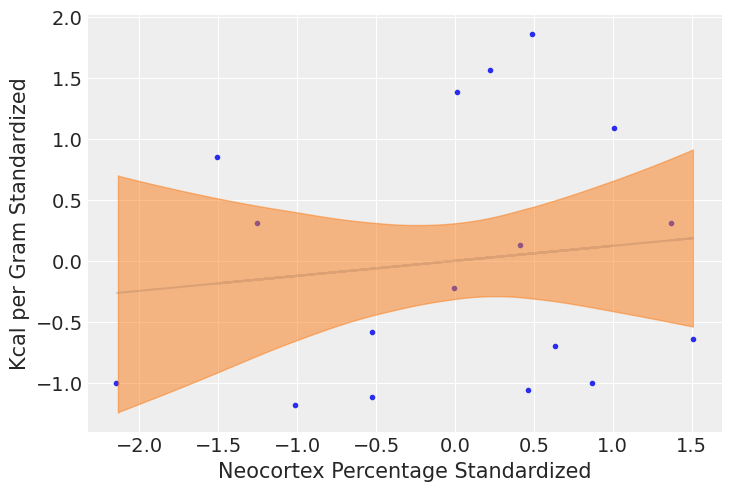

In [14]:
_, ax = plt.subplots(1, 1)

neocortex_stan = df['neocortex.perc_stan']
kcal_stan = df['kcal.per.g_stan']

ax.scatter(neocortex_stan, kcal_stan, marker='.')

ax.plot(neocortex_stan, mu_means, 'k-', alpha=0.1)

az.plot_hdi(neocortex_stan, np.expand_dims(df_mu.values, 0), ax=ax)

ax.set_xlabel('Neocortex Percentage Standardized')
ax.set_ylabel('Kcal per Gram Standardized')

plt.show()

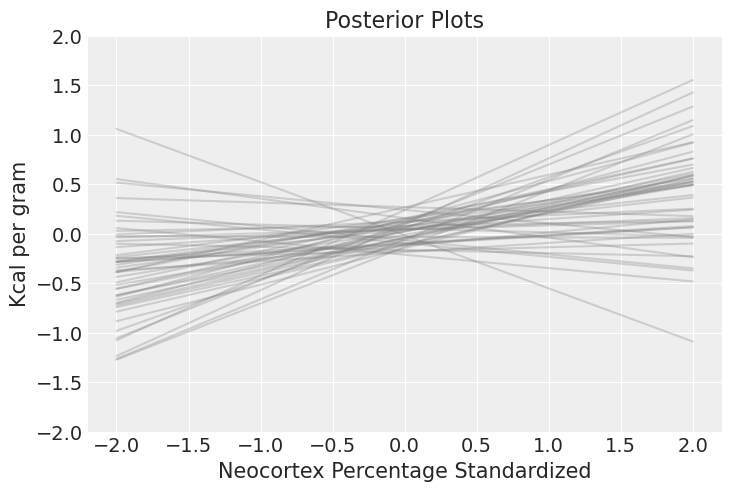

In [15]:
N = 50
xvals = np.linspace(-2, 2, num=100)

sample = df_trace_5_5[['alpha', 'beta_N']].sample(N)

_, ax = plt.subplots(1, 1)

for i in range(N):
    line = [sample.iloc[i, 0] + sample.iloc[i, 1] * x for x in xvals]
    ax.plot(xvals, line, color='grey', alpha=0.3)

ax.set_ylim(-2, 2)
ax.set_xlabel('Neocortex Percentage Standardized')
ax.set_ylabel('Kcal per gram')

plt.title('Posterior Plots')

plt.show()

## Energy vs Body Mass

$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_M \cdot \log M_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.37

In [16]:
with pm.Model() as m_5_6:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * df['log_mass_stan'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_6 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 6 seconds.


In [17]:
az.summary(trace_5_6, var_names=['alpha', 'beta_M', 'sigma'])

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.155,-0.299,0.287,0.001,0.001,20261.0,9908.0,20285.0,14164.0,1.0
beta_M,-0.285,0.224,-0.712,0.124,0.002,0.001,22154.0,17541.0,22341.0,14386.0,1.0
sigma,1.017,0.193,0.700,1.379,0.001,0.001,18770.0,17377.0,20012.0,12858.0,1.0


In [18]:
df_tr_5_6 = pm.trace_to_dataframe(trace_5_6)
df_tr_5_6.head()

,alpha,beta_M,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16
0,0.114590,-0.200949,0.971426,0.203690,0.097562,0.095140,0.176638,0.316578,0.502452,0.356158,0.397350,0.228290,0.149281,0.006332,0.095140,-0.107187,-0.193545,-0.122000,-0.099779,-0.154063
1,-0.234177,-0.506634,1.062973,-0.009539,-0.277110,-0.283215,-0.077743,0.275077,0.743705,0.374865,0.478720,0.052484,-0.146713,-0.507120,-0.283215,-0.793324,-1.011052,-0.830672,-0.774647,-0.911509
2,-0.314104,-0.467187,1.173831,-0.106956,-0.353694,-0.359324,-0.169850,0.155500,0.587640,0.247518,0.343287,-0.049762,-0.233450,-0.565795,-0.359324,-0.829716,-1.030491,-0.864156,-0.812492,-0.938698
3,0.064519,-0.594205,0.979075,0.327985,0.014165,0.007004,0.247992,0.661797,1.211426,0.778833,0.900638,0.400729,0.167100,-0.255602,0.007004,-0.591276,-0.846637,-0.635079,-0.569370,-0.729888
4,-0.143465,-0.676531,0.751563,0.156504,-0.200795,-0.208948,0.065428,0.536565,1.162344,0.669816,0.808497,0.239326,-0.026671,-0.507938,-0.208948,-0.890119,-1.180861,-0.939992,-0.865179,-1.047937


In [19]:
df_mu_5_6 = df_tr_5_6.filter(regex='mu.*')
mu_means_5_6 = df_mu_5_6.apply(np.mean) 

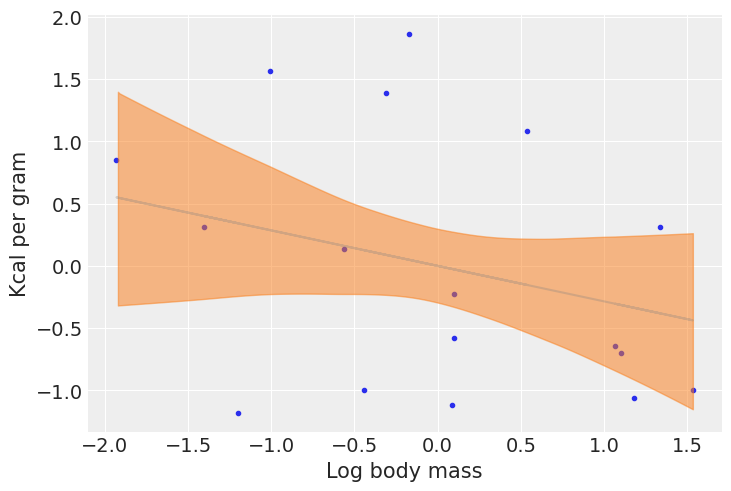

In [20]:
_, ax = plt.subplots(1, 1)

ax.scatter(df['log_mass_stan'], df['kcal.per.g_stan'], marker='.')
ax.plot(df['log_mass_stan'], mu_means_5_6, color='grey', alpha=0.3)

az.plot_hdi(df['log_mass_stan'], np.expand_dims(df_mu_5_6.values, 0), ax=ax)

ax.set_xlabel('Log body mass')
ax.set_ylabel('Kcal per gram')

plt.show()

## Joint Regression Model

$$
\begin{align*}
    K_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & = \alpha + \beta_M \cdot \log M_i + \beta_N \cdot N_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \beta_N & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.38

In [21]:
with pm.Model() as m_5_7:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    beta_N = pm.Normal('beta_N', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * df['log_mass_stan'] + beta_N * df['neocortex.perc_stan'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df['kcal.per.g_stan'])
    
    trace_5_7 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [22]:
az.summary(trace_5_7, var_names=['alpha', 'beta_M', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.143,-0.228,0.228,0.001,0.001,13270.0,9728.0,13261.0,13195.0,1.0
beta_M,-0.674,0.268,-1.122,-0.266,0.003,0.002,9224.0,9224.0,9310.0,10745.0,1.0
beta_N,0.570,0.268,0.157,1.000,0.003,0.002,9291.0,9291.0,9346.0,10759.0,1.0
sigma,0.831,0.172,0.580,1.084,0.002,0.001,9693.0,9693.0,9319.0,8824.0,1.0


In [23]:
summary_5_5 = az.summary(trace_5_5, hdi_prob=0.89)
summary_5_6 = az.summary(trace_5_6, hdi_prob=0.89)
summary_5_7 = az.summary(trace_5_7, hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less 

### Code 5.39

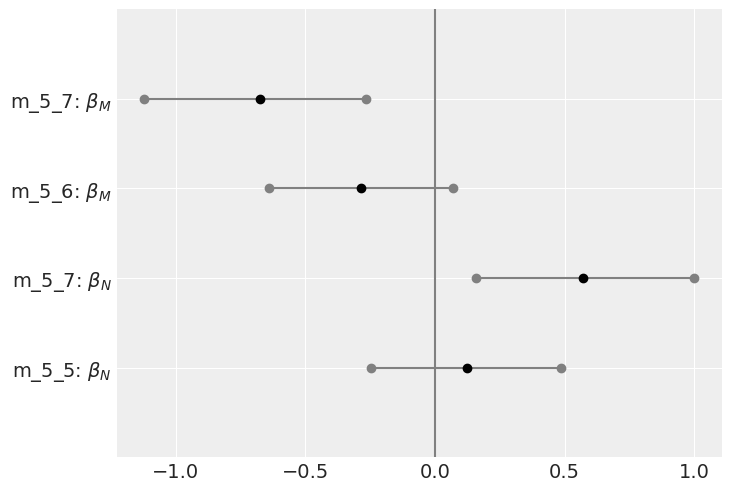

In [24]:
summary_list = [(summary_5_5, 'beta_N', 1), 
                (summary_5_7, 'beta_N', 2), 
                (summary_5_6, 'beta_M', 3), 
                (summary_5_7, 'beta_M', 4)]


_, ax = plt.subplots(1, 1)


for summary, var, y_level in summary_list:
    lower = summary.loc[var, 'hdi_5.5%']
    upper = summary.loc[var, 'hdi_94.5%']
    mid = summary.loc[var, 'mean']

    ax.plot((lower, upper), (y_level, y_level), 'o-', color='grey')
    ax.plot((mid), (y_level), 'ko')

ax.vlines(x=0, ymin=0, ymax=5, color='grey')
ax.set_ylim(0, 5)
plt.yticks([1, 2, 3, 4], [r'm_5_5: $\beta_N$', r'm_5_7: $\beta_N$', r'm_5_6: $\beta_M$', r'm_5_7: $\beta_M$'])

plt.show()

In [25]:
df[['log_mass_stan', 'neocortex.perc_stan']].corr()

,log_mass_stan,neocortex.perc_stan
log_mass_stan,1.000000,0.750376
neocortex.perc_stan,0.750376,1.000000


## Discussion

In the context of this discussion, we let $K$ denote the energy content of milk in kcal per gm; $N$ denote the neocortex percentage; and, $M$ denote the (logarithm) of the body mass.

In this case, the two predictor variables $N$ and $M$ are strongly positively correlated. The reponse $K$, however, is positively correlated with $N$ and negatively correlated with $M$. When we regress $K$ against both $N$ and $M$, the slopes $b_{N}$ and $b_{M}$ are greater than when $K$ is regressed against $N$ alone or against $M$ alone. In the joint regression, $N$ and $M$ tend to cancel each other out and hence the slopes $b_N$ and $b_M$ are larger.   

## Counterfactual Plots

In [26]:
df_tr_5_7 = pm.trace_to_dataframe(trace_5_7)
df_mu_5_7 = df_tr_5_7.filter(regex='(mu.*)')

mu_means_5_7 = df_mu_5_7.apply(np.mean)
mu_means_5_7.head()

mu__0   -0.924393
mu__1   -0.356128
mu__2   -0.364249
mu__3    0.214473
mu__4    0.802970
dtype: float64

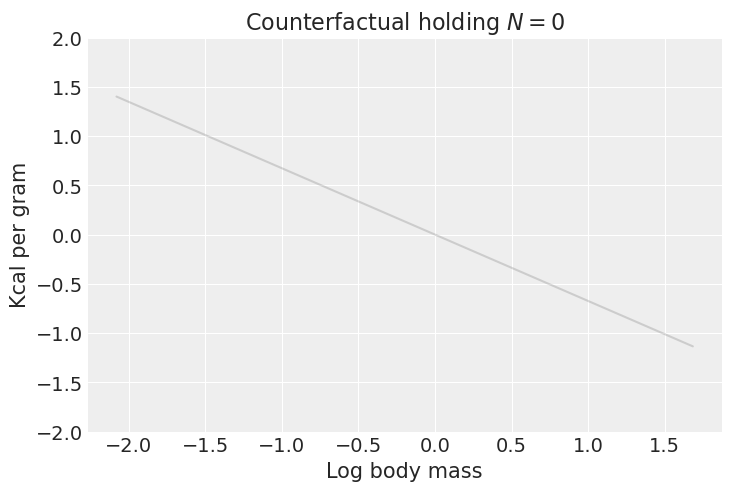

In [27]:
alpha = summary_5_7.loc['alpha', 'mean']
beta_M = summary_5_7.loc['beta_M', 'mean']
beta_N = summary_5_7.loc['beta_N', 'mean']

log_body_mass = np.linspace(df['log_mass_stan'].min() - 0.15, df['log_mass_stan'].max() + 0.15, num=50)

counterfactual = alpha + beta_M * log_body_mass

_, ax = plt.subplots(1, 1)

ax.plot(log_body_mass, counterfactual, color='grey', alpha=0.3)

# az.plot_hdi(df['log_mass_stan'], np.expand_dims(mu_means_5_7, 0), ax=ax)

ax.set_xlabel('Log body mass')
ax.set_ylabel('Kcal per gram')
ax.set_ylim(-2.0, 2.0)

plt.title(r'Counterfactual holding $N = 0$')

plt.show()

## Simulating Masked Relationships

### Code 5.41

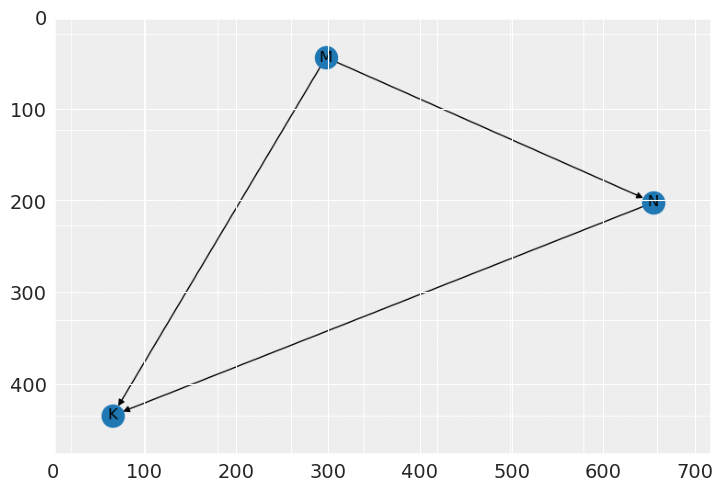

In [28]:
import networkx as nx


dag_1 = nx.DiGraph()
dag_1.add_edges_from([("M", "N"), ("M", "K"), ("N", "K")])

plt.tight_layout()
nx.draw_networkx(dag_1, arrows=True)

plt.savefig("dag_1.png", format="PNG")
plt.clf()

plt.imshow(plt.imread("dag_1.png", format="PNG"))

In [29]:
# M -> N
# M -> K <- N

num_samples = 100
M = norm.rvs(loc=0, scale=1, size=num_samples)
N = norm.rvs(loc=M, scale=1, size=num_samples)

# K is positive correlated with N and negatively correlated with M
K = norm.rvs(loc=N-M, scale=1, size=num_samples)

df_sim_1 = pd.DataFrame({'M': M, 'N': N, 'K': K})
df_sim_1.head()

,M,N,K
0,0.010488,-0.436546,1.043993
1,-1.212070,-1.220792,0.036849
2,-1.237334,-0.964855,0.321998
3,-0.645446,-1.817084,-1.347986
4,-0.406851,-1.964190,-2.771014


In [30]:
with pm.Model() as m_sim_1a:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_N = pm.Normal('beta_N', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_N * df_sim_1['N'])
    K = pm.Normal('kilocal', mu=mu, sigma=sigma, observed=df_sim_1['K'])
    
    trace_1a = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 6 seconds.


In [31]:
summary_1a = az.summary(trace_1a, var_names=['alpha', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [32]:
with pm.Model() as m_sim_1b:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * df_sim_1['M'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df_sim_1['K'])
    
    trace_1b = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


In [33]:
summary_1b = az.summary(trace_1b, var_names=['alpha', 'beta_M', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [34]:
with pm.Model() as m_sim_1c:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    beta_N = pm.Normal('beta_N', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * df_sim_1['M'] + beta_N * df_sim_1['N'])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=df_sim_1['K'])
    
    trace_1c = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 7 seconds.


In [35]:
summary_1c = az.summary(trace_1c, var_names=['alpha', 'beta_M', 'beta_N', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


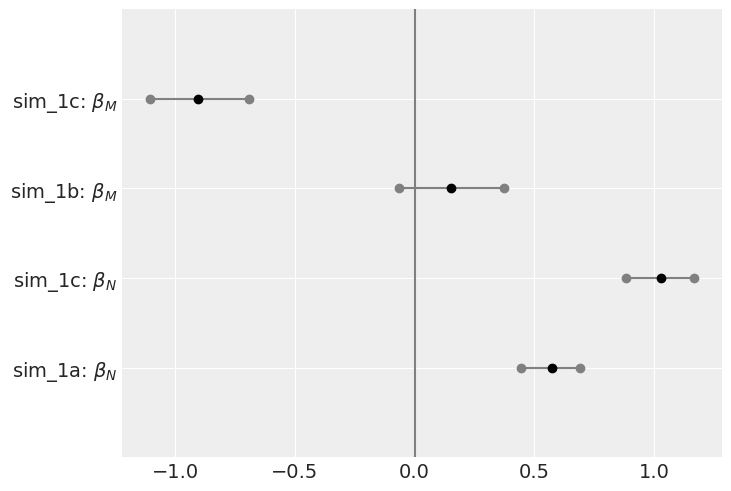

In [36]:
summary_list = [(summary_1a, 'beta_N', 1), 
                (summary_1c, 'beta_N', 2), 
                (summary_1b, 'beta_M', 3), 
                (summary_1c, 'beta_M', 4)]


_, ax = plt.subplots(1, 1)


for summary, var, y_level in summary_list:
    lower = summary.loc[var, 'hdi_5.5%']
    upper = summary.loc[var, 'hdi_94.5%']
    mid = summary.loc[var, 'mean']

    ax.plot((lower, upper), (y_level, y_level), 'o-', color='grey')
    ax.plot((mid), (y_level), 'ko')

ax.vlines(x=0, ymin=0, ymax=5, color='grey')
ax.set_ylim(0, 5)
plt.yticks([1, 2, 3, 4], [r'sim_1a: $\beta_N$', r'sim_1c: $\beta_N$', r'sim_1b: $\beta_M$', r'sim_1c: $\beta_M$'])

plt.show()